In [1]:
from emulator_utils.pre_process import log_standard, unscale
from emulator_utils.read_data import readpowerspec
from emulator_utils.split import random_holdout
from emulator_utils.surrogates import simple_mlp, train_mlp, save_mlp, load_mlp

In [2]:
import matplotlib.pylab as plt
import numpy as np
from glob import glob

### Read some spectra

Text(0, 0.5, 'Pk')

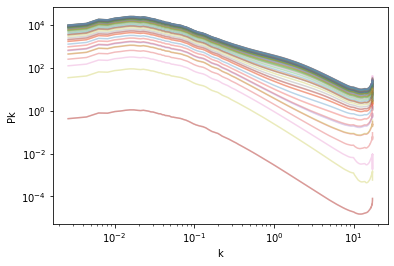

In [3]:
k, _, _, _ = readpowerspec('../test/data/powerspec_LJ/m000p.pk.499')
fnames = glob('../test/data/powerspec_LJ/*')
pk_all = np.array([readpowerspec(f)[1] for f in fnames])


plt.figure(1)
plt.plot(k, pk_all.T, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('Pk')

### Using a pre-processing pipeline.(First log10, then a standardization)

Text(0, 0.5, 'Pk')

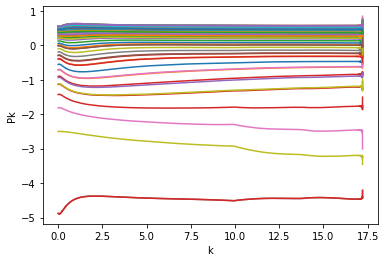

In [4]:
scaled, scaler = log_standard(pk_all)

plt.plot(k, scaled.T)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('k')
plt.ylabel('Pk')

### Scaling back to original units

Text(0, 0.5, 'Pk')

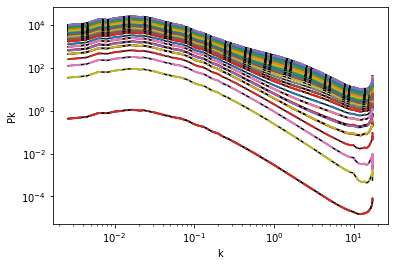

In [5]:
pk_unscale = unscale(scaled, scaler)


plt.plot(k, pk_unscale.T, 'k')
plt.plot(k, pk_all.T, '-.', lw=2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('Pk')

In [46]:
params = np.zeros(shape= (scaled.shape[0], 5))
params[:, 0] = np.arange(scaled.shape[0])

In [47]:
pk_train, pk_test, param_train, param_test = random_holdout(scaled, params, split_fraction = 0.2)

In [48]:
# from tensorflow.keras import Sequential
# from keras.models import Model
# from tensorflow.keras.layers import Dense, Conv1D, Activation, Dropout, Flatten, Input
# import tensorflow as tf
# from tensorflow.keras import backend as K
# tf.random.set_seed(3)


# # def simple_mlp(input_shape, output_shape, hidden_dims):
# #     '''
# #     Parameters
# #     input_shape: integer 
# #     output_shape: integer
# #     hidden dim: numpy array with integers

# #     TO-DO: add options for changing loss and optimizer

# #     '''

# #     model = Sequential()
# #     model.add(Dense(hidden_dims[0], activation='relu', kernel_initializer='he_normal', input_shape=(input_shape,)))
    
# #     for hidden_shape in hidden_dim[1:]:
# #         model.add(Dense(hidden_shape, activation='relu', kernel_initializer='he_normal'))

# #     model.add(Dense(output_shape, activation='linear'))

# #     # compile the model
# #     model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])

# #     print(model.summary())

# #     return model

In [49]:
input_shape = 5
output_shape = pk_train.shape[1]
hidden_dims = np.array([16, 32, 64, 512])

In [50]:
# model = Sequential()

# model.add(Dense(hidden_dims[0], activation='relu', kernel_initializer='he_normal', input_shape=(input_shape,)))
    
# for hidden_shape in hidden_dims[1:]:
#     model.add(Dense(hidden_shape, activation='relu', kernel_initializer='he_normal'))

# model.add(Dense(output_shape, activation='linear'))

# # compile the model
# model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])

# print(model.summary())

In [51]:
# param_train.shape, pk_train.shape

In [52]:
# model.input_shape, model.output_shape

In [53]:
# model.fit(param_train, pk_train, epochs=2, batch_size=4, verbose=0)

In [45]:
mlp = simple_mlp(input_shape, output_shape, hidden_dims)
mlp = train_mlp(model, param_train, pk_train, param_test, pk_test, 0.01, 0.1, 100, 4)

save_mlp(mlp, '../test/model/trained_mlp')
mlp = load_mlp('../test/model/trained_mlp')

1/1 [==============================] - 16s 16s/step - loss: 0.3514 - mean_squared_error: 0.3514
Test Accuracy: 0.351


TypeError: save_mlp() takes 1 positional argument but 2 were given